# The 10 most polarizing movies on IMDB

Let's all agree that Pixar's *Inside Out* is great! At least that's what its IMDB ratings suggest. IMDB and similarly Rotten Tomatoes, are making it pretty easy for us to find great movies like *Inside Out* with their rankings (see [Top 250 on IMDB](http://www.imdb.com/chart/top)). It is likewise easy to find movies that are not worthy of anyone's time, but could be interesting to take a quick look at to see how bad a movie can be -- you could checkout [The 40 Worst Movies of All Time](http://www.imdb.com/list/ls076596691/). 

But then, there are those "love it or hate it" types of movies. Those movies can be hard to find among the usual movie rankings: their average scores are likely to be mediocre, and therefore hidden among those other ones that most people agree are just, yes, mediocre. We need a way to rank what movies are the most polarizing, which we can then use as a starting point to uncover the actual hidden gems that are worth watching.

I will now present you with exactly that: a ranking of movies on IMDB by how polarizing they are to viewers.

I have loaded all the IMDB movies via IMDB's [database interface](http://www.imdb.com/interfaces). Let's dig in by first taking a look at the distribution of movies ratings.  

In [1]:
from IPython.core.display import HTML, display
# http://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()">
<input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
from __future__ import unicode_literals
from __future__ import print_function

import os
import re
import warnings
import pprint
import html
import pandas as pd
import numpy as np
from scipy import stats

import pylab as pl
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)

# This option is set so that long urls can be displayed with 80 chars 
# they dissapear 
pd.set_option('display.max_colwidth', 160)

def showdf(df):
    display(HTML(df.to_html(escape=False)))
    
pp = pprint.PrettyPrinter(indent=4)

# Run tests for many of the functions here 
run_tests = False

# If you want run this function then you have to first download the raw data from IMDB: http://www.imdb.com/interfaces.
list_to_csv = False

"""Code to process imdb list data
Notes to loading 
* Not treating (YYYYII examples)
* I am keeping everything as strings and letting pandas later do the conversion
* I could make better episode processing, but my main interest is movies
* I choose not to not include movies with year given as (????)
"""

p_year = re.compile('\([12][890]\d{2}\)')  # Finding year of movie   
p_episode = re.compile('\{.*\}')  # Finding episode string
p_media = re.compile('\(\D*\)')  # Finding media if tagged


def rating_process(line, min_votes=100, verbose=0):
    
    entries = [elem for elem in line.split(' ') if len(elem) > 0]
    
    out = {}
    out['distribution'] = entries[0]
    out['votes'] = entries[1]    
    out['rating'] = entries[2]
    
    if int(out['votes']) < min_votes:
        return None
    
    title_year_episode = ' '.join(entries[3:])

    
    try:
        year = p_year.findall(title_year_episode)[0][1:-1]
        title = p_year.split(title_year_episode)[0].strip()
        episode = ''
        other_string = p_year.split(title_year_episode)[1]
        episode_findall = p_episode.findall(other_string)
        if len(episode_findall) == 1:
            episode = episode_findall[0][1:-1]
            episode = episode_findall[0]

        media = ''
        media_findall = p_media.findall(other_string)
        if len(media_findall):
            media = media_findall[0][1:-1]
        
        int(year)
    # TODO: Change exception to be explicit on what I will except here.
    except :
        if verbose > 0:
            print('WARNING this file did not process', 
                   title_year_episode.strip())
        return None
    
    if title[0] == '"' and title[-1] == '"':
        title = title[1:-1]
    out['year'] = year
    out['title'] = title
    out['episode'] = episode
    out['media'] = media    
    return out
 
examples = [
#     Real examples
    '1....521.1      10   6.3  ".hack//Tasogare no udewa densetsu" (2003) {Densetsu no yusha (#1.1)}\n',
    '      0000001212   16660   7.6  "12 Monkeys" (2015)\n',
    '      ....1.34.1       9   7.6  "1st Look" (2011) {Columbiana (#1.9)}\n',
#     This one has a different year format
    '1000011003      58   6.5  "Amas de casa desesperadas" (2006/II)\n',
    '.....161..       6   7.0  "Amateurs" (2014) {(#1.1)}\n',
#     This one stops using "" for the title 
    '030.0..1.3      21   5.8  Struggle (2002)\n',
#     Includes a (V) and uses '' in the title
    "....112.02      11   7.5  The Making of 'The Mummy: Tomb of the Dragon Emperor' (2008) (V)\n",
#   Year not given here  
    '2........7       9   8.0  "By Any Means" (????)\n',
#   Other types of movies
    '0000000017   28338   9.7  Grand Theft Auto V (2013) (VG)\n',
    '.....1.511       7   8.1  Grand Theft Auto: San Andreas - The Introduction (2004) (V)\n'
]

if run_tests:
    for example in examples: 
        print(example[:-1])
        pp.pprint(rating_process(example, min_votes=1, verbose =3)) 
        print()

# Make CSV file of the intries
def imdb_list_to_csv(min_votes=1000):
    entries = [
        'rating', 'votes', 'title', 'episode', 'year', 'distribution', 
        'media', ]

    # http://stackoverflow.com/questions/21129020/how-to-fix-unicodedecodeerror-ascii-codec-cant-decode-byte
    with open('ratings.list', 'r', encoding="cp1250") as f:
        for k in range(500):
            line = f.readline()
            if 'MOVIE RATINGS REPORT' in line:
                break
        for k in range(2):
            f.readline()
        num_movies = 0
        with open('ratings.csv', 'w') as fcsv:
            fcsv.write(';'.join(entries)+'\n')
            for k in range(int(1e6)):# 
                line = f.readline()
                if len(line.split('\n')[0].strip()): 
                    d = rating_process(line, min_votes=min_votes)
                    if d:
                        line_csv = ';'.join([d[entry] for entry in entries])+'\n'
                        fcsv.write(line_csv)
                        num_movies += 1
                else:
                    break

            print("Number of movies %i \n" % k, 
                  "movies with more than %i votes: %i" % (min_votes, num_movies))

if list_to_csv:
    imdb_list_to_csv(min_votes=1000)

#### Loading the data: 
After filtering out entries that i) are obvious TV shows and computer games, and/or ii) have less than 1000 votes, we get:

In [3]:
reader = pd.read_csv('ratings.csv', 
                     sep=';', 
                     iterator=True, 
                     header=0, na_values=[' ', ''], 
                     chunksize=1000, 
                     error_bad_lines=False,
                     warn_bad_lines=False)
top_movies = []

df_chunks = []
for i, df_chunk in enumerate(reader):
    df_chunks.append(df_chunk)
    
df = pd.concat(df_chunks)
df.reset_index(inplace = True)

def get_movies_only(df):
    df_new = df[df['episode'].isnull()][df['media'].isnull()]
    return df_new

def imdb_google_link(row):
    return (
        '<a href="http://www.google.com/search?q=%s&btnI">%s</a>' 
        % (' '.join(['imdb', row['title'], str(row['year'])]), row['title']))

def wikipedia_google_link(row):
    return (
        '<a href="http://www.google.com/search?q=%s&btnI">%s</a>' 
        % ((' '.join(['wikipedia', 'movie', row['title'], str(row['year'])])), 
           'wiki: '+row['title']))

df['Title'] = df.apply(imdb_google_link, axis=1)
df['Wikipedia link'] = df.apply(wikipedia_google_link, axis=1)

with warnings.catch_warnings():
    # We get a userwarning for reindexing which we filter out here
    warnings.simplefilter("ignore")
    df = get_movies_only(df)
    warnings.resetwarnings()

print('%i entries in our dataset' % len(df))

25454 entries in our dataset


### Distribution of ratings
IMDB allows people to give a rating between 1 and 10 for each movie. Let's take a look at the rating distribution across all the movies in the dataset:

Mean 6.63 and median 6.8


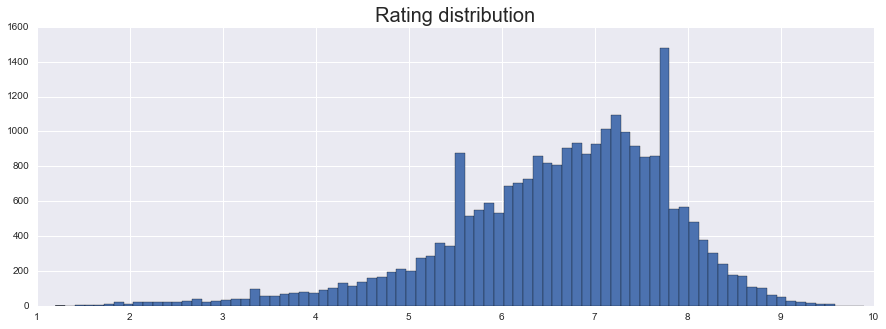

In [4]:
df['rating'].hist(bins=len(df['rating'].unique())-1)
pl.title('Rating distribution', fontsize=20)
print('Mean %.2f' % df['rating'].mean(), 'and median', df['rating'].median());

## Finding polarizing movies
Let's take a look at the rating distribution around the average for the movies in the dataset.

In [5]:
"""
REPORT FORMAT
=============

     In this list, movies have been rated on a scale of 1 to 10, 10 being
good and 1 being bad.  For each movie, the total number of votes, the
average rating, and the vote distribution are shown.  New movies are indicated
by a "*" before their entry.

     The vote distribution uses a single character to represent the percentage
of votes for each ranking.  The following characters codes can appear:

     "." no votes cast        "3" 30-39% of the votes  "7" 70-79% of the votes
     "0"  1-9%  of the votes  "4" 40-49% of the votes  "8" 80-89% of the votes
     "1" 10-19% of the votes  "5" 50-59% of the votes  "9" 90-99% of the votes
     "2" 20-29% of the votes  "6" 60-69% of the votes  "*" 100%   of the votes
"""
p_dist_att = re.compile('[\d*.]{10}')

def p_to_prop(p):
    if p == '.':
        r = 0.
    elif p == '*':
        r = 1.
    else:
        r=int(p)*0.1
    return r

def dist_to_props(dist):
    
    if type(dist) is float:
        dist = int(dist)
    dist = str(dist)
    
    if len(dist) < 10:
        dist = '0'*(10-len(dist))+dist
    
    # testing if the dist ahere to the format:
    if p_dist_att.match(dist) and len(dist) == 10:
        props = np.array([p_to_prop(p) for p in dist])
        # adding what is not accounted for when we take
        # the lower bound of all the percentages: 
        # i.e. 10%-19%: take it as 10% 
        if props.sum() > 1.:
            print('This is not a valid distribution %s' % dist)
            props = None
        else:
            props += (1. - props.sum())/10. 
    else:
        props = None
        
    return props

if run_tests:
    print(dist_to_props('4310000000') is not None)
    print(dist_to_props('4378234782234') is None)
    print(dist_to_props('234') is not None)
    print(dist_to_props(21100121.0) is not None)
    # This one should fail but it is OK for now 
    print(dist_to_props('.........*') is not None  )
    print(dist_to_props('..1......*') is None) # sum to > 1  


In [6]:
def props_to_avg(props):
    W_scores = [(i+1)*prop for i, prop in enumerate(props)] 
    return np.sum(W_scores)

def props_to_std(props):
#     Weighted standard deviation / 2nd moment: 
#     http://www.itl.nist.gov/div898/software/dataplot/refman2/ch2/weightsd.pdf
    std = np.sqrt(np.sum(props*(range(1, 11)-props_to_avg(props))**2))
    return std

def dist_to_avg(dist):
    props = dist_to_props(dist)
    if props is not None:
        r = props_to_avg(props)
    else:
        r = np.NaN
        print('problem with ', dist)
    return r

def dist_to_std(dist):
    props = dist_to_props(dist)
    if props is not None:
        r = props_to_std(props)
    else:
        r = np.NaN
        print('problem with ', dist)
    return r

if run_tests:
    print('testing distribution stats:')
    print(df.loc[0])
    print()
    print('std:', dist_to_std(df['distribution'][0]))
    print('dist avg', dist_to_avg(df['distribution'][0]))
    print('real rating', df['rating'][0])


In [7]:
# adding new stats
df['dist_std'] = df['distribution'].apply(dist_to_std)
df['dist_avg'] = df['distribution'].apply(dist_to_avg)

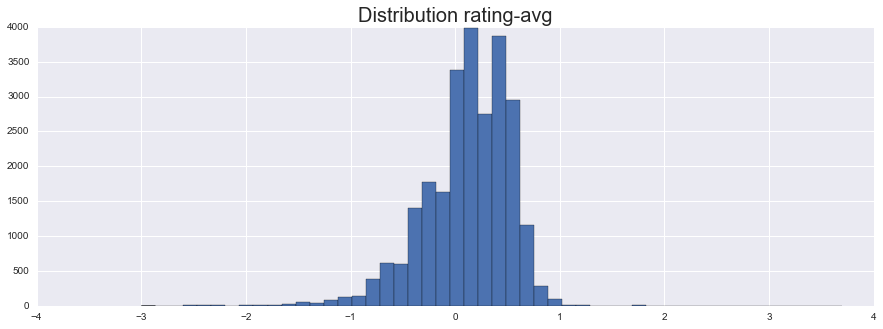

In [8]:
# How bad is the estimating of the rating

(df['rating']-df['dist_avg']).hist(bins=50)
pl.title('Distribution rating-avg', fontsize=20);

And next, let's see the distribution of standard deviations:

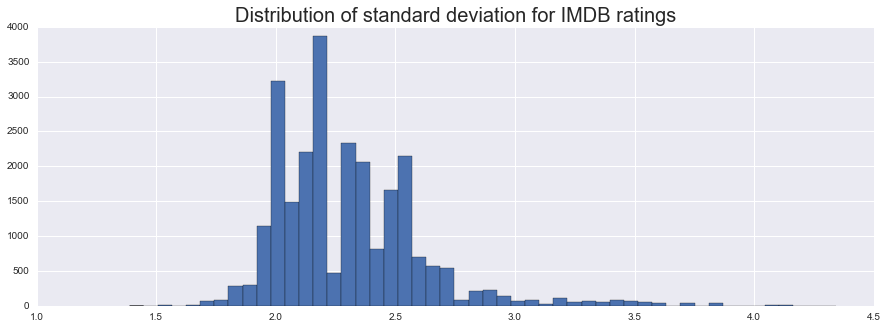

In [9]:
df['dist_std'].hist(bins=50);
pl.title('Distribution of standard deviation for IMDB ratings', fontsize=20);

Here we see that the movie distribution has a medium around 2.25, and with a small ramp up at small standard deviations, and a fat tail of movies with high standard deviation. Let's get to the fun part: which ones are the most polarizing movies?

### 10 most polarizing movies
A polarizing movie will have ratings with large  [standard deviation](https://en.wikipedia.org/wiki/Standard_deviation), so let's start by ranking all the movies by their standard deviation, here abbreviated as dist_std.

In [10]:
showdf(
df[['Title','Wikipedia link', 'rating', 'year', 'votes', 'dist_std']
   ].sort_values('dist_std', ascending=False)[:10]
)

,Title,Wikipedia link,rating,year,votes,dist_std
10311,Audacity,wiki: Audacity,4.7,2015,3978,4.341371
22450,Night Train to Mundo Fine,wiki: Night Train to Mundo Fine,2.7,1966,5832,4.224926
31338,Troppo belli,wiki: Troppo belli,2.9,2005,4404,4.224926
19025,Kis Vuk,wiki: Kis Vuk,2.2,2008,7292,4.150602
30266,The Starfighters,wiki: The Starfighters,2.3,1964,2995,4.127953
15134,Fat Slags,wiki: Fat Slags,2.6,2004,3549,4.127953
21760,Monster a-Go Go,wiki: Monster a-Go Go,2.3,1965,6200,4.127953
31008,Titanic - La leggenda continua,wiki: Titanic - La leggenda continua,2.1,2000,7653,4.127953
12813,Cool Cat Saves the Kids,wiki: Cool Cat Saves the Kids,3.7,2015,2071,4.127953
10904,Ben & Arthur,wiki: Ben & Arthur,2.2,2002,6915,4.127953


Movies with the highest standard deviation tend to have quite low average ratings, with the exception of number 1. Let's take a look at it:

![Ratings by Gender for Audacity](figures/Audacity__2015__-_User_ratings.png)

There is a huge difference in the average rating of men and women, which explains a lot of the polarization here. The IMDB rating dataset unfortunately doesn't include the distribution of male vs female votes -- it would have been interesting to find movies that are the most divided by gender, and for that matter also country, age, etc.

Take a look at these movies; you might find something interesting. I have also added a link for each movie that looks up its Wikipedia entry in case you are curious (it doesn't work for the first one though).

### Polarizing movies with high average ratings

Let's find the polarizing movies with an average rating of more than 7, as such a search might return movies that are more likely to be worth watching. 

In [11]:
showdf(
df[df['rating'] > 7.0
  ][['Title', 'rating', 'year', 'votes', 'dist_std']
  ].sort_values('dist_std', ascending=False)[:10]
)

,Title,rating,year,votes,dist_std
10102,Aquarius,7.5,2016,5793,3.822303
25111,Sausage Party,7.5,2016,1890,3.494281
30796,Theri,7.6,2016,5295,3.494281
9354,Adolf Hitler: The Greatest Story Never Told,7.7,2013,1997,3.404042
4983,Rebelde Way,7.2,2002,1555,3.389690
21311,Meet the Mormons,7.1,2014,1698,3.350746
5268,Shahrzad,8.7,2015,1741,3.350746
16293,Gopala Gopala,7.7,2015,2735,3.350746
30631,The Weight of Chains,8.3,2010,3487,3.350746
8109,"Tim and Eric Awesome Show, Great Job!",7.3,2007,8433,3.316625


Number one is Aquarius: another movie that women love and men in general would love to hate.

Another interesting find on this list is number 4, about Adolf Hitler. 

![Ratings of Adolf Hitler: The Greatest Story Never Told](figures/Adolf_Hitler__The_Greatest_Story_Never_Told__2013__-_User_ratings.png)

We see that about 20% of its votes are 1s, whereas the majority 65% are 10s. I would be curious to find out what drives the 20% to give it 1; perhaps they just voted it 1 because the movie is about Adolf Hitler. I find it hard to imagine that the movie is really that bad if so many voted it 10.

Let's see what the most polarizing movies are with an average rating higher than 8.

In [12]:
showdf(
df[df['rating'] > 8.0
  ][['Title', 'rating', 'year', 'votes', 'dist_std'
    ]].sort_values('dist_std', ascending=False)[:10]
)

,Title,rating,year,votes,dist_std
5268,Shahrzad,8.7,2015,1741,3.350746
30631,The Weight of Chains,8.3,2010,3487,3.350746
4779,Planet Earth,9.5,2006,98627,3.207803
4301,Monty Python's Flying Circus,8.9,1969,43995,3.091925
3834,Life,9.2,2009,22836,3.091925
7597,The Twilight Zone,9.0,1959,43607,3.091925
25706,Sicilian Vampire,8.8,2015,8120,3.031089
22885,Om,8.8,1995,1236,2.872281
29665,The Parlor,8.2,2001,1045,2.872281
11003,Bey Yaar,8.7,2014,1518,2.872281


Here number one, Shahrzad, is a movie that especially young people love and elderly people dislike quite a lot.

### Least polarizing movies:
Let's also check out which movies are the least polarizing.

In [13]:
showdf(
    df[['Title', 'rating', 'year', 'votes', 'dist_std']].sort_values('dist_std', ascending=True)[:10]
)

,Title,rating,year,votes,dist_std
23091,Ouija: Game Never Ends,8.7,2015,2611,1.388344
1649,Den andra sporten,8.8,2013,1158,1.465435
18452,Joe Kidd,6.5,1972,12295,1.552417
11304,Blood Work,6.4,2002,34105,1.552417
28872,The Invisible Man Returns,6.5,1940,1994,1.552417
24627,Rob the Mob,6.3,2014,8565,1.552417
28841,The Indian Fighter,6.4,1955,1336,1.552417
22000,Murder!,6.4,1930,4095,1.552417
18274,Janis: Little Girl Blue,7.4,2015,1438,1.564449
13377,De nieuwe wildernis,7.3,2013,1269,1.577973


It’s interesting to note that here that we get a good mix of movies with average ratings ranging from mediocre to high. The ratings are consistently high for the first two movies, while consistently mediocre for the rest.

It’s interesting to note that here, we get a good mix of movies with average ratings ranging from mediocre to high. The ratings are consistently high for the first two movies, while consistently mediocre for the rest.

So here in the end, let's take a look at the most and least polarizing movies with more than 10.000 votes:

In [14]:
showdf(
df[df['votes'] > 10000][
                        ['Title', 'rating', 'year', 'votes', 'dist_std']
                        ].sort_values('dist_std', ascending=False)[:10]
)

,Title,rating,year,votes,dist_std
22944,One Direction: This Is Us,4.1,2013,22092,4.055552
26738,Superbabies: Baby Geniuses 2,1.9,2004,25163,3.822303
18506,Jonas Brothers: The 3D Concert Experience,2.1,2009,17118,3.822303
23636,Pledge This!,1.9,2006,15272,3.822303
13202,Daniel der Zauberer,2.0,2004,12613,3.822303
29994,The Room,3.5,2003,29880,3.779881
16162,God's Not Dead,4.9,2014,30778,3.747999
24126,Ra.One,4.8,2011,31327,3.747999
13897,Dilwale,5.4,2015,21003,3.747999
23811,Prem Ratan Dhan Payo,4.9,2015,10147,3.612478


Number 1 here has 38.5% of reviewers giving it 10s and 42.5% 1s, and again a large difference between the ratings of men and women, where women tend to like it. Maybe not all that surprising for a movie about a boyband's rise to fame.

And lastly the movies with least polarization:

In [15]:
showdf(
df[df['votes'] > 10000][
                        ['Title', 'rating', 'year', 'votes', 'dist_std']
                        ].sort_values('dist_std', ascending=True)[:10]
)

,Title,rating,year,votes,dist_std
11304,Blood Work,6.4,2002,34105,1.552417
18452,Joe Kidd,6.5,1972,12295,1.552417
32721,X-Men,7.4,2000,446901,1.700000
18042,Invictus,7.4,2009,122821,1.700000
19995,Le prénom,7.3,2012,10023,1.700000
13207,Dans la maison,7.4,2012,21993,1.700000
19930,Le gamin au vélo,7.4,2011,20905,1.700000
9554,Alice Doesn't Live Here Anymore,7.4,1974,15405,1.700000
19862,Layer Cake,7.4,2004,132896,1.700000
29301,The Man Who Knew Too Much,7.5,1956,41687,1.700000


where we mostly get mediocre to good (but not great) movies. 

## Trends over years - more movies gives rise to larger variance

We might be wondering whether movies have become more polarizing over time. Let's see what the trend is.

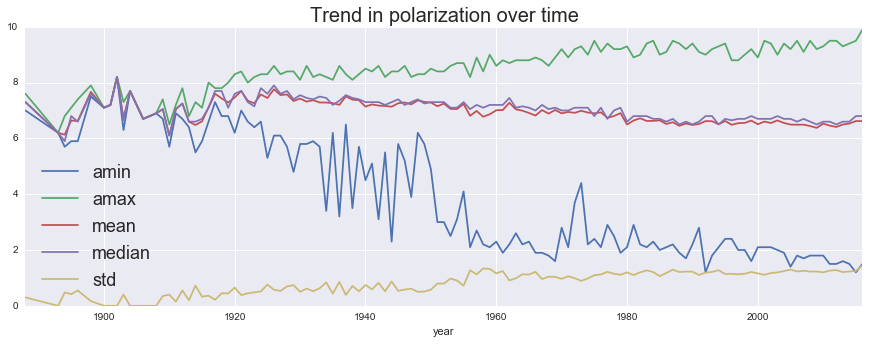

In [16]:
for func in [np.min, np.max, np.mean, np.median, np.std]:
    df.groupby('year')['rating'].apply(func).plot(label=func.__name__);
pl.legend(loc=3, fontsize=18);
pl.title('Trend in polarization over time', fontsize=20);

This graph can be interpreted to say that newer movies are more polarizing. However, this could be driven by the larger number of recent movies on IMDB as we will see below. A lot of old movies are not listed on IMDB. I would guess that only the best movies make the cut; their mediocre counterparts could have easily been lost, destroyed, or hidden away by the movie studios.

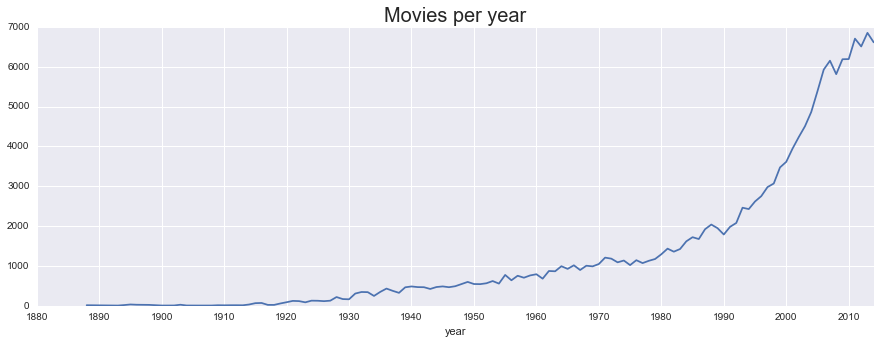

In [17]:
df[df['year'] < 2015].groupby('year')['rating'].apply(np.sum).plot(xticks=range(1880, 2020, 10))
pl.title('Movies per year', fontsize=20);

## Final Thoughts
Thank you for joining me on this journey. Here are a couple of things that I’ve learned:
- There are definitely some very polarizing movies on IMDB that could potentially be hidden gems (I haven't watched any of the ones I found here yet). Please let me know if find something worthwhile.
- The most polarizing movies tend to be polarized over gender.
- The larger number of polarizing movies that are recent could be explained by the fact that there are just a lot more recent movies on IMDB, and the older ones that made it on IMDB are likely to the ones that people in general like.


There is a number of ways that I (or you) could extend this exploration. Below are a couple of things that I have thought about:

- It would be quite interesting explore what movies tend to polarize over, e.g. gender, age, race, country, income. Currently, I don't have the data available, but IMDB have the data to do this, so we could imagine that it would be possible in the future. 
- I would also love to see if it was possible to make a predictive model that tell if a movie was polarizing or not given whatever data is available about it. I think it would be challenging to do this well with the current available data, and it would only really be interested if we could do this for movies where we didn't have the ratings. 
 
One potential problem with this dataset is that most of the users who rate the movies are self-selected. It would probably look different if IMDB had taken a random sample of our population, asked them to watch a movie and rate it afterwards. What we have here are instead ratings of people who had been lured into watching a given movie either by trailers, commercials, or rankings like the ones we’ve seen. 

Every movie, however, has a target audience, and perhaps the more polarizing ones could’ve done a better job at targeting the right segment. Either that, or maybe guys should be better at saying no to their girlfriends when they are invited to watch a chick flick. 
 
I hope you’ve enjoyed the read. Let me know if you have ideas for other things that would be interesting to look at.

Keld

PS: I have made the code available on [github](https://github.com/keldLundgaard).



### Acknowledgements
I owe a lot of credit to my movie loving cousin [Mads Lundgaard](http://www.imdb.com/name/nm1400845/), who told me about the hidden information in the movie rating distribution many years ago. 

A warm thank you also goes to Hanh Nguyen for editing. 

